In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, OneHotEncoder

In [3]:
df = pd.read_csv("/kaggle/input/data-environment/data.csv", encoding='cp1252', low_memory=False)
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [5]:
df.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [6]:
df.dtypes

stn_code                        object
sampling_date                   object
state                           object
location                        object
agency                          object
type                            object
so2                            float64
no2                            float64
rspm                           float64
spm                            float64
location_monitoring_station     object
pm2_5                          float64
date                            object
dtype: object

In [7]:
df.nunique()

stn_code                        745
sampling_date                  5485
state                            37
location                        304
agency                           64
type                             10
so2                            4197
no2                            6864
rspm                           6065
spm                            6668
location_monitoring_station     991
pm2_5                           433
date                           5067
dtype: int64

In [8]:
df.isnull().sum()

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

In [9]:
df.duplicated().sum()

674

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

In [12]:
df = df.drop(columns=['sampling_date', 'stn_code'])

# Qualitative and quantitative

In [13]:
list1 = df.select_dtypes(include=['float64', 'int64']).columns
list1

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5'], dtype='object')

In [14]:
list2 = df.select_dtypes(include=['object']).columns
list2

Index(['state', 'location', 'agency', 'type', 'location_monitoring_station',
       'date'],
      dtype='object')

In [15]:
df.isna().sum()

state                               0
location                            3
agency                         149466
type                             5357
so2                             34632
no2                             16222
rspm                            40035
spm                            236908
location_monitoring_station     27303
pm2_5                          425754
date                                7
dtype: int64

In [16]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') 
df['date']

0        1990-02-01
1        1990-02-01
2        1990-02-01
3        1990-03-01
4        1990-03-01
            ...    
435737   2015-12-24
435738   2015-12-29
435739          NaT
435740          NaT
435741          NaT
Name: date, Length: 435068, dtype: datetime64[ns]

In [17]:
data = df

In [18]:
grp_state = data.groupby('state')

In [19]:
def impute_mean_by_state(series):
    return series.fillna(series.mean()) 

In [20]:
data['rspm']=grp_state['rspm'].transform(impute_mean_by_state) 
data['so2']=grp_state['so2'].transform(impute_mean_by_state)
data['no2']=grp_state['no2'].transform(impute_mean_by_state)
data['spm']=grp_state['spm'].transform(impute_mean_by_state)
data['pm2_5']=grp_state['pm2_5'].transform(impute_mean_by_state)

In [21]:
data.describe()

,so2,no2,rspm,spm,pm2_5,date
count,435065.000000,435065.000000,435065.000000,430997.000000,123598.000000,435061
mean,10.589643,25.676550,109.719689,215.228162,48.323205,2010-01-12 22:22:11.780141312
min,0.000000,0.000000,0.000000,0.000000,3.000000,1987-01-01 00:00:00
25%,4.800000,14.000000,59.000000,142.000000,30.729696,2007-07-03 00:00:00
50%,8.000000,21.800000,93.000000,205.272744,42.204089,2010-11-11 00:00:00
75%,13.000000,32.000000,142.008536,248.000000,64.890625,2013-09-08 00:00:00
max,909.000000,876.000000,6307.033333,3380.000000,504.000000,2015-12-31 00:00:00
std,10.855480,18.265916,72.552443,117.476948,21.457277,NaN


In [22]:
data.isna().sum()

state                               0
location                            3
agency                         149466
type                             5357
so2                                 3
no2                                 3
rspm                                3
spm                              4071
location_monitoring_station     27303
pm2_5                          311470
date                                7
dtype: int64

# AQI

### AQI (Air Quality Index) là chỉ số đo chất lượng không khí, phản ánh mức độ ô nhiễm và tác động đến sức khỏe con người. 
### Dựa trên nồng độ các chất ô nhiễm chính như PM2.5, PM10, NO₂, SO₂, CO, và O₃, AQI được phân thành các mức từ tốt (0-50) đến nguy hại (301+). 
### Chỉ số này giúp cảnh báo sức khỏe, giám sát môi trường, và hỗ trợ quyết định chính sách.

### Trong bài báo lần này sử dụng AQI là chuẩn cho không khi để thực hiện train model và xử lý

# [Refer to article (AQI)](https://vietcleanair.vn/chi-so-chat-luong-khong-khi-aqi-duoc-tinh-nhu-the-nao/)


$$ AQI_x = \left( \frac{TS_x}{QC_x} \right) \times 100 $$
### TS_x :  Giá trị quan trắc trung bình 1 giờ của thông số X
### QC_x :  Giá trị quy chuẩn trung bình 1 giờ của thông số X

# Overall AQI
$$ AQI = \max(AQI_{SO_2}, AQI_{NO_2}, AQI_{PM_{10}}, AQI_{PM_{2.5}}, AQI_{CO}, AQI_{O_3}) $$


### AQI được tính toán cho từng thông số quan trắc khác nhau. 
### Mỗi thông số sẽ xác định được một giá trị AQI cụ thể. 
### Tại Việt Nam, các thông số thường được sử dụng có quy định trong QCVN 05:2013/BTNMT bao gồm: SO2, CO, NO2, O3, TSP, bụi thô (PM10), bụi mịn (PM2.5), Pb(chì).

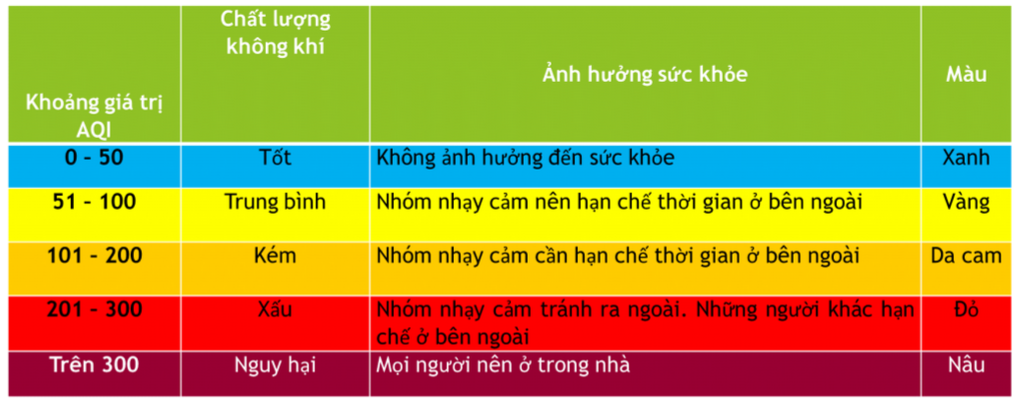

In [23]:
def visualization_oulizer(so2, no2, rspm, spm, pm2_5):
    outlier_counts = {
    'SO₂': so2,
    'NO₂': no2,
    'RSPM': rspm,
    'SPM': spm,
    'PM₂.₅': pm2_5
    }
    outlier_df = pd.DataFrame(list(outlier_counts.items()), 
                              columns=['Pollutant', 'Outlier Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(outlier_df['Pollutant'], outlier_df['Outlier Count'])
    plt.xlabel('Ten cot')
    plt.ylabel('So luong')
    plt.title('Outliers')
    plt.show()

# Calculate AQI

### Công thức tính chỉ số chất lượng môi trường không khí của chất ô nhiễm

# $$ I_p = \frac{I_{Hi} - I_{Lo}}{BP_{Hi} - BP_{Lo}} (C_p - BP_{Lo}) + I_{Lo} $$ 

#### Trong đó:
### - $I_p$: Chỉ số chất lượng môi trường không khí của chất ô nhiễm $p$
### - $C_p$: Nồng độ của chất ô nhiễm $p$
### - $BP_{Hi}$: Chỉ số trên của $C_p$
### - $BP_{Lo}$: Chỉ số dưới của $C_p$
### - $I_{Hi}$: Giá trị AQI trên tương ứng với $BP_{Hi}$
### - $I_{Lo}$: Giá trị AQI dưới tương ứng với $BP_{Lo}$


### Tính So2

In [24]:
def cal_SOi(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    elif (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    elif (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    elif (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/420)
    elif (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    elif (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
data['SOi']=data['so2'].apply(cal_SOi)
df= data[['so2','SOi']]
df.head()

,so2,SOi
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


### Tính No2

In [25]:
def cal_Noi(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-40)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
data['Noi']=data['no2'].apply(cal_Noi)
df= data[['no2','Noi']]
df.head()

,no2,Noi
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


### Tính Rspm

In [26]:
def cal_RSPMi(rspm):
    rpi=0
    if(rspm<=100):
     rpi = rspm
    elif(rspm>=101 and rspm<=150):
     rpi= 101+(rspm-101)*((200-101)/(150-101))
    elif(rspm>=151 and rspm<=350):
     ni= 201+(rspm-151)*((300-201)/(350-151))
    elif(rspm>=351 and rspm<=420):
     ni= 301+(rspm-351)*((400-301)/(420-351))
    elif(rspm>420):
     ni= 401+(rspm-420)*((500-401)/(420-351))
    return rpi
data['RSPMi']=data['rspm'].apply(cal_RSPMi)
df= data[['rspm','RSPMi']]
df.head()

,rspm,RSPMi
0,78.249162,78.249162
1,78.249162,78.249162
2,78.249162,78.249162
3,78.249162,78.249162
4,78.249162,78.249162


### Tính Spm

In [27]:
def cal_SPMi(spm):
    spi=0
    if(spm<=50):
     spi=spm*50/50
    elif(spm>50 and spm<=100):
     spi=50+(spm-50)*(50/50)
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)*(100/100)
    elif(spm>350 and spm<=430):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/430)
    return spi
   
data['SPMi']=data['spm'].apply(cal_SPMi)
df= data[['spm','SPMi']]
df.head()

,spm,SPMi
0,200.336016,166.890678
1,200.336016,166.890678
2,200.336016,166.890678
3,200.336016,166.890678
4,200.336016,166.890678


### Tính Pm2_5

In [28]:
def cal_pmi(pm2_5):
    pmi=0
    if(pm2_5<=50):
     pmi=pm2_5*(50/50)
    elif(pm2_5>50 and pm2_5<=100):
     pmi=50+(pm2_5-50)*(50/50)
    elif(pm2_5>100 and pm2_5<=250):
     pmi= 100+(pm2_5-100)*(100/150)
    elif(pm2_5>250 and pm2_5<=350):
     pmi=200+(pm2_5-250)*(100/100)
    elif(pm2_5>350 and pm2_5<=450):
     pmi=300+(pm2_5-350)*(100/100)
    else:
     pmi=400+(pm2_5-430)*(100/80)
    return pmi
data['PMi']=data['pm2_5'].apply(cal_pmi)
df= data[['pm2_5','PMi']]
df.head()

,pm2_5,PMi
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


# Calculate overall AQI

In [29]:
def cal_aqi(si,ni,rspmi,spmi):
    aqi=0
    if(si>ni and si>rspmi and si>spmi):
     aqi=si
    if(ni>si and ni>rspmi and ni>spmi ):
     aqi=ni
    if(rspmi>si and rspmi>ni and rspmi>spmi ):
     aqi=rspmi
    if(spmi>si and spmi>ni and spmi>rspmi):
     aqi=spmi
    return aqi

data['AQI']=data.apply(lambda x:cal_aqi(x['SOi'],x['Noi'],x['RSPMi'],x['SPMi']),axis=1)
df= data[['state','SOi','Noi','RSPMi','SPMi','AQI']]
df.head()

,state,SOi,Noi,RSPMi,SPMi,AQI
0,Andhra Pradesh,6.000,21.750,78.249162,166.890678,166.890678
1,Andhra Pradesh,3.875,8.750,78.249162,166.890678,166.890678
2,Andhra Pradesh,7.750,35.625,78.249162,166.890678,166.890678
3,Andhra Pradesh,7.875,18.375,78.249162,166.890678,166.890678
4,Andhra Pradesh,5.875,9.375,78.249162,166.890678,166.890678


# Standardize air quality data output

Thống nhất chuẩn label:
+ 1 Rất kém
+ 2 Kém
+ 3 Trung bình
+ 4 Khá
+ 5 Tốt
+ 6 Rất tốt

In [30]:
def AQI_Range(x):
    if x<=50:
        return 6
    elif x>50 and x<=100:
        return 5
    elif x>100 and x<=200:
        return 4
    elif x>200 and x<=300:
        return 3
    elif x>300 and x<=400:
        return 2
    elif x>400:
        return 1

data['AQI_Range'] = data['AQI'].apply(AQI_Range)
data.head()

,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date,SOi,Noi,RSPMi,SPMi,PMi,AQI,AQI_Range
0,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,78.249162,200.336016,NaN,NaN,1990-02-01,6.000,21.750,78.249162,166.890678,NaN,166.890678,4
1,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,78.249162,200.336016,NaN,NaN,1990-02-01,3.875,8.750,78.249162,166.890678,NaN,166.890678,4
2,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,78.249162,200.336016,NaN,NaN,1990-02-01,7.750,35.625,78.249162,166.890678,NaN,166.890678,4
3,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,78.249162,200.336016,NaN,NaN,1990-03-01,7.875,18.375,78.249162,166.890678,NaN,166.890678,4
4,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,78.249162,200.336016,NaN,NaN,1990-03-01,5.875,9.375,78.249162,166.890678,NaN,166.890678,4


In [31]:
data['AQI_Range'].value_counts()

AQI_Range
4    259411
5     57222
3     48746
2     39644
1     18673
6     11372
Name: count, dtype: int64

In [32]:
data.columns

Index(['state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm',
       'location_monitoring_station', 'pm2_5', 'date', 'SOi', 'Noi', 'RSPMi',
       'SPMi', 'PMi', 'AQI', 'AQI_Range'],
      dtype='object')

In [33]:
data = data.drop(columns=['so2', 'no2', 'rspm', 'spm','PMi', 'AQI', 'pm2_5', 'location_monitoring_station', 'agency', 'location', 'type'])

In [34]:
data.head()

,state,date,SOi,Noi,RSPMi,SPMi,AQI_Range
0,Andhra Pradesh,1990-02-01,6.000,21.750,78.249162,166.890678,4
1,Andhra Pradesh,1990-02-01,3.875,8.750,78.249162,166.890678,4
2,Andhra Pradesh,1990-02-01,7.750,35.625,78.249162,166.890678,4
3,Andhra Pradesh,1990-03-01,7.875,18.375,78.249162,166.890678,4
4,Andhra Pradesh,1990-03-01,5.875,9.375,78.249162,166.890678,4


In [35]:
top_5_states = data['state'].value_counts().head(5).index
df_filtered = data[data['state'].isin(top_5_states)].copy()  

In [36]:
df_filtered = df_filtered.set_index('date')

In [37]:
df_filtered['state'].value_counts()

state
Maharashtra       60286
Uttar Pradesh     42775
Andhra Pradesh    26158
Punjab            25634
Rajasthan         25566
Name: count, dtype: int64

In [38]:
df_filtered['AQI_Range'].value_counts()

AQI_Range
4    106339
2     30005
3     25626
1     11947
5      5459
6      1043
Name: count, dtype: int64

In [39]:
df_filtered.head()

,state,SOi,Noi,RSPMi,SPMi,AQI_Range
date,,,,,,
1990-02-01,Andhra Pradesh,6.000,21.750,78.249162,166.890678,4
1990-02-01,Andhra Pradesh,3.875,8.750,78.249162,166.890678,4
1990-02-01,Andhra Pradesh,7.750,35.625,78.249162,166.890678,4
1990-03-01,Andhra Pradesh,7.875,18.375,78.249162,166.890678,4
1990-03-01,Andhra Pradesh,5.875,9.375,78.249162,166.890678,4


In [40]:
df_filtered.columns

Index(['state', 'SOi', 'Noi', 'RSPMi', 'SPMi', 'AQI_Range'], dtype='object')

In [41]:
df_filtered.isna().sum()

state        0
SOi          0
Noi          0
RSPMi        0
SPMi         0
AQI_Range    0
dtype: int64

In [42]:
df_filtered = df_filtered.sort_index()
df_filtered

,state,SOi,Noi,RSPMi,SPMi,AQI_Range
date,,,,,,
1987-01-01,Rajasthan,9.575501,38.025118,183.853980,101.333333,4
1987-01-01,Uttar Pradesh,20.125000,34.522554,0.000000,127.333333,4
1987-01-01,Rajasthan,9.575501,38.025118,183.853980,70.000000,4
1987-01-02,Uttar Pradesh,20.250000,6.125000,0.000000,432.790698,1
1987-01-04,Punjab,13.285748,35.107308,0.000000,177.333333,4
...,...,...,...,...,...,...
2015-12-31,Maharashtra,18.750000,41.250000,73.000000,170.181829,4
2015-12-31,Maharashtra,17.500000,47.500000,143.428571,170.181829,4
2015-12-31,Uttar Pradesh,1.250000,41.250000,0.000000,328.261944,2


# Visualization

### SOi - State

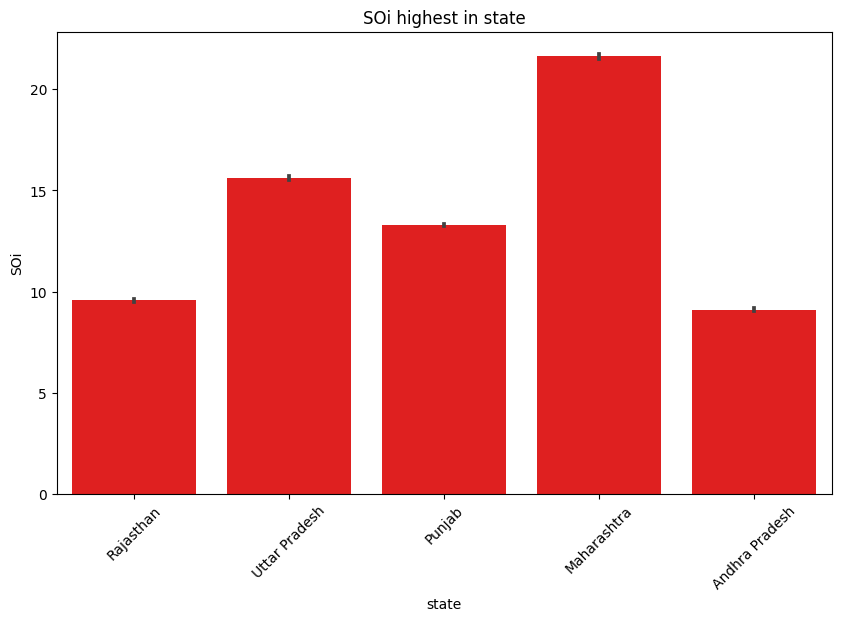

In [43]:
a=df_filtered[['SOi','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['SOi'],data=a,color='red')
plt.title('SOi highest in state')
plt.xticks(rotation=45)
plt.show()

### NOi - State

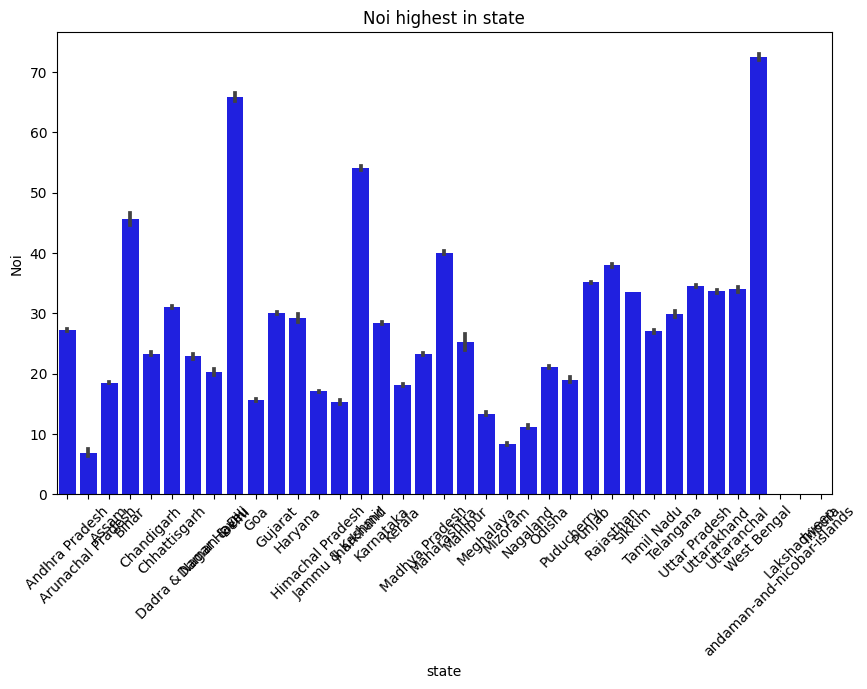

In [44]:
a=df[['Noi','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['Noi'],data=a,color='blue')
plt.title('Noi highest in state')
plt.xticks(rotation=45)
plt.show()

### RSPMi - State

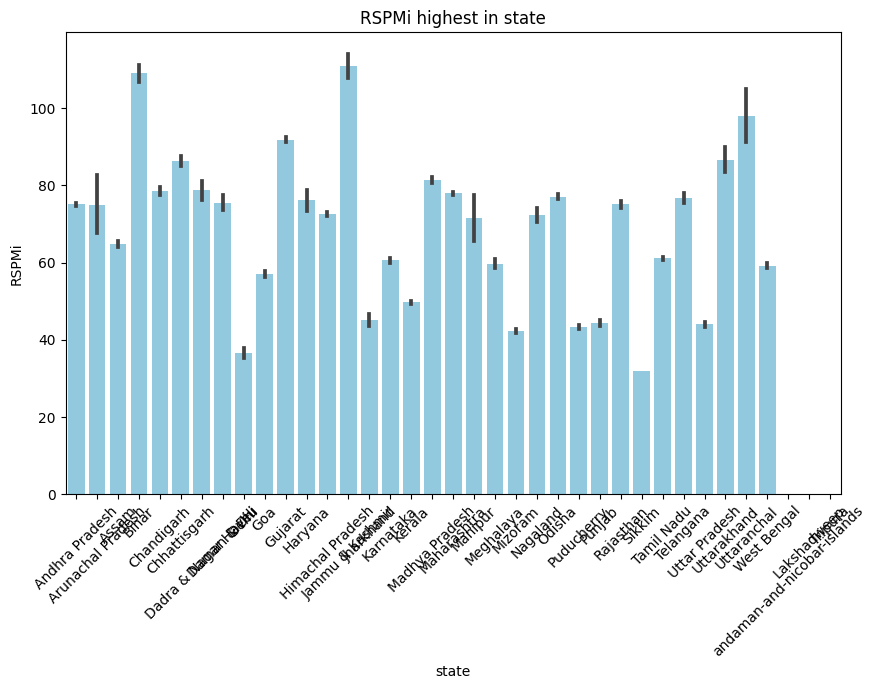

In [45]:
a=df[['RSPMi','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['RSPMi'],data=a,color='skyblue')
plt.title('RSPMi highest in state')
plt.xticks(rotation=45)
plt.show()

### SPMi - State

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


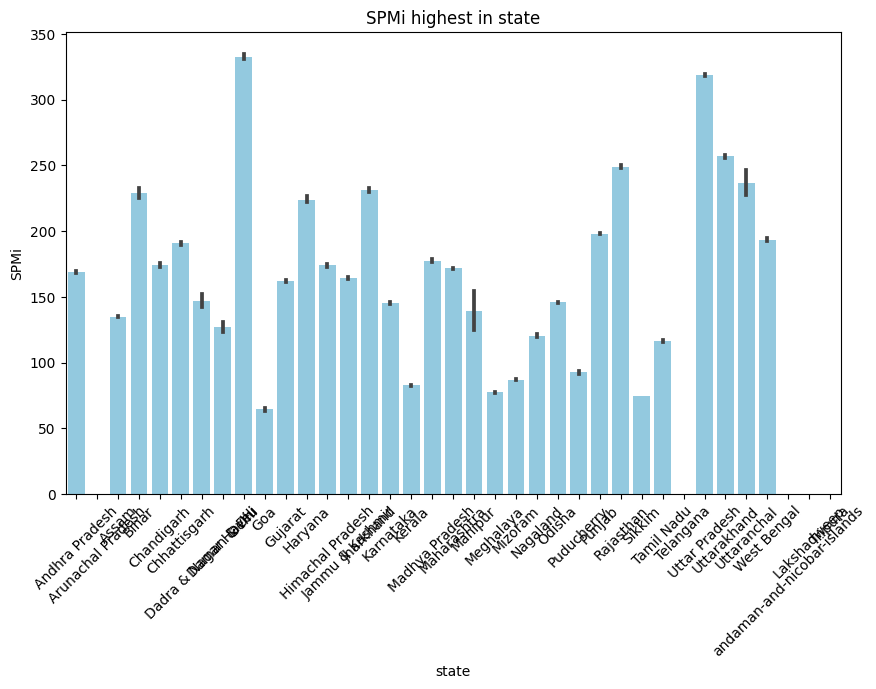

In [46]:
a=df[['SPMi','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['SPMi'],data=a,color='skyblue')
plt.title('SPMi highest in state')
plt.xticks(rotation=45)
plt.show()

### Correlation

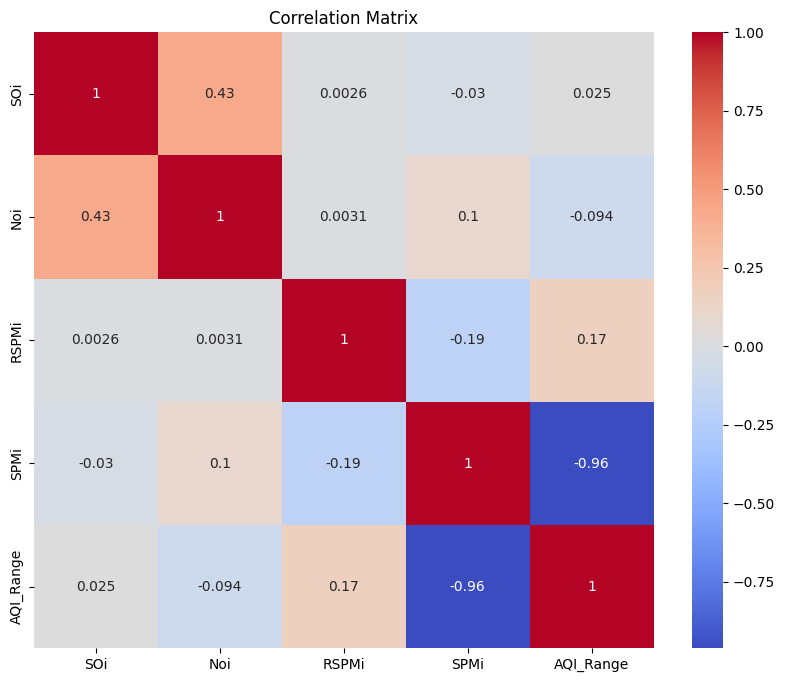

In [47]:
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_filtered[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Process date NaN

In [48]:
df_filtered.index.isna().sum()

2

In [49]:
df_filtered = df_filtered[df_filtered.index.notna()]

In [50]:
df_filtered.index.isna().sum()

0

# Info LSTM

### LSTM (Long Short-Term Memory) là một loại mạng nơ-ron hồi tiếp (RNN - Recurrent Neural Network) được thiết kế đặc biệt để xử lý và dự đoán trên dữ liệu chuỗi thời gian hoặc dữ liệu có thứ tự (sequential data).

### LSTM khắc phục nhược điểm của RNN truyền thống trong việc học các phụ thuộc dài hạn (long-term dependencies) bằng cách sử dụng cơ chế "bộ nhớ" (memory cell) và các cổng (gates) để kiểm soát luồng thông tin.

# Long Short-Term Memory (LSTM)

## **1. LSTM là gì?**
LSTM (**Long Short-Term Memory**) là một loại mạng nơ-ron hồi tiếp (**RNN**) được thiết kế để xử lý và dự đoán dữ liệu chuỗi thời gian hoặc dữ liệu có thứ tự (sequential data). LSTM vượt qua các hạn chế của RNN truyền thống nhờ cơ chế bộ nhớ và cổng, giúp xử lý hiệu quả các phụ thuộc dài hạn (**long-term dependencies**).

---

## **2. Các thành phần chính của LSTM**

### **2.1. Cell State $ C_t $ **
- Là bộ nhớ dài hạn của LSTM.
- Được cập nhật trong mỗi bước thời gian thông qua các cổng.

### **2.2. Hidden State $ h_t $**
- Là bộ nhớ ngắn hạn, biểu thị ngữ cảnh hiện tại.
- Được sử dụng làm đầu ra tại mỗi bước thời gian.

### **2.3. Gates**
1. Forget Gate $ f_t $ : Quyết định thông tin nào từ trạng thái trước cần quên.
2. Input Gate $ i_t $ : Quyết định thông tin mới nào cần thêm vào bộ nhớ.
3. Output Gate $ o_t $ : Quyết định phần nào của bộ nhớ được xuất ra.

---

## **3. Công thức toán học trong LSTM**

### **3.1. Forget Gate**
#### $ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $

- $f_t$: Xác định thông tin nào cần quên từ $C_{t-1}$.
- $sigma$: Hàm sigmoid, giá trị trong khoảng $(0, 1)$.

### **3.2. Input Gate và Candidate Memory**
#### $ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $
#### $ tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) $
- $i_t$: Quyết định thông tin mới nào sẽ được thêm vào $C_t$.
- $tilde{C}_t$: Bộ nhớ tiềm năng mới.

### **3.3. Cập nhật Cell State**
#### $ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $
- $odot$: Phép nhân từng phần tử (Hadamard).

### **3.4. Output Gate và Hidden State**
#### $ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $
#### $ h_t = o_t \odot \tanh(C_t) $
- $h_t$: Kết hợp giữa $C_t$ và $o_t$ để tạo đầu ra.

---

## **4. Các hàm kích hoạt**

1. **Sigmoid**:
   #### $sigma(x) = \frac{1}{1 + e^{-x}} $
   - Giá trị trong khoảng \( (0, 1) \).
   - Dùng cho \( f_t, i_t, o_t \).


2. **Tanh**:
   #### $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $
   - Giá trị trong khoảng $ (-1, 1) $.
   - Dùng cho $ \tilde{C}_t $ và $ h_t $.

---

## **5. Lợi ích toán học của LSTM**

1. **Học phụ thuộc dài hạn**:
   - LSTM có khả năng ghi nhớ thông tin dài hạn nhờ trạng thái $ C_t $.

2. **Giảm vấn đề Vanishing Gradient**:
   - Các cổng của LSTM giúp duy trì gradient ổn định qua nhiều bước thời gian.

3. **Xử lý chuỗi thời gian phức tạp**:
   - LSTM học được các mối quan hệ phi tuyến giữa các bước thời gian.

---

## **6. Khi nào sử dụng LSTM?**

1. **Dữ liệu chuỗi thời gian**:
   - Ví dụ: Dự đoán giá cổ phiếu, dự báo thời tiết, hoặc chất lượng không khí.

2. **Quan hệ dài hạn trong dữ liệu**:
   - Khi dữ liệu hiện tại phụ thuộc vào dữ liệu từ các bước trước đó.

3. **Dữ liệu phi tuyến**:
   - Khi quan hệ giữa đầu vào và đầu ra không tuyến tính.

---

## **7. Hạn chế của LSTM**

1. **Tốn tài nguyên**:
   - Quá trình huấn luyện LSTM chậm và yêu cầu nhiều tài nguyên tính toán.

2. **Cần dữ liệu lớn**:
   - LSTM cần lượng dữ liệu lớn để đạt hiệu quả cao.

3. **Khó tối ưu hóa**:
   - Cần tinh chỉnh nhiều tham số như số tầng, số lượng nơ-ron, và dropout.

---

## **8. Khi nào không nên dùng LSTM?**

1. **Dữ liệu nhỏ**:
   - Khi không có đủ dữ liệu, các mô hình truyền thống như ARIMA, Random Forest có thể hiệu quả hơn.

2. **Không có phụ thuộc dài hạn**:
   - Nếu không có mối quan hệ dài hạn, LSTM có thể không cần thiết.

---

# Model training

In [51]:
# ma hoa state tren 5 state da chon
encoder = OneHotEncoder(sparse_output=False)
state_encoded = encoder.fit_transform(df_filtered[['state']])
state_columns = [f"state_{cat}" for cat in encoder.categories_[0]]
state_df = pd.DataFrame(state_encoded, index=df_filtered.index, columns=state_columns)


In [52]:
# ghep du lieu voi du lieu state
df_filtered = pd.concat([df_filtered, state_df], axis=1)
df_filtered

,state,SOi,Noi,RSPMi,SPMi,AQI_Range,state_Andhra Pradesh,state_Maharashtra,state_Punjab,state_Rajasthan,state_Uttar Pradesh
date,,,,,,,,,,,
1987-01-01,Rajasthan,9.575501,38.025118,183.853980,101.333333,4,0.0,0.0,0.0,1.0,0.0
1987-01-01,Uttar Pradesh,20.125000,34.522554,0.000000,127.333333,4,0.0,0.0,0.0,0.0,1.0
1987-01-01,Rajasthan,9.575501,38.025118,183.853980,70.000000,4,0.0,0.0,0.0,1.0,0.0
1987-01-02,Uttar Pradesh,20.250000,6.125000,0.000000,432.790698,1,0.0,0.0,0.0,0.0,1.0
1987-01-04,Punjab,13.285748,35.107308,0.000000,177.333333,4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,Uttar Pradesh,36.250000,62.500000,0.000000,328.261944,2,0.0,0.0,0.0,0.0,1.0
2015-12-31,Maharashtra,33.750000,73.750000,0.000000,170.181829,4,0.0,1.0,0.0,0.0,0.0
2015-12-31,Maharashtra,18.750000,41.250000,73.000000,170.181829,4,0.0,1.0,0.0,0.0,0.0


In [53]:
df_filtered.columns

Index(['state', 'SOi', 'Noi', 'RSPMi', 'SPMi', 'AQI_Range',
       'state_Andhra Pradesh', 'state_Maharashtra', 'state_Punjab',
       'state_Rajasthan', 'state_Uttar Pradesh'],
      dtype='object')

In [54]:
# chon cot 
input_features = ['SOi', 'Noi', 'RSPMi', 'SPMi'] + state_columns
output_feature = 'AQI_Range'
input_features, output_feature 

(['SOi',
  'Noi',
  'RSPMi',
  'SPMi',
  'state_Andhra Pradesh',
  'state_Maharashtra',
  'state_Punjab',
  'state_Rajasthan',
  'state_Uttar Pradesh'],
 'AQI_Range')

In [55]:
# chuan hoa du lieu dau vao
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_filtered[input_features + [output_feature]])


In [56]:
# tao du lieu chuoi thoi gian
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1]) 
        y.append(data[i+time_steps, -1]) 
    return np.array(X), np.array(y)


In [57]:
time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

In [58]:
# chia du lieu huan luyen kiem tra
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [59]:
# model LSTM
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

In [60]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
# huan luyen mo hinh
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0480 - val_loss: 0.0291
Epoch 2/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0442 - val_loss: 0.0294
Epoch 3/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0434 - val_loss: 0.0292
Epoch 4/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0431 - val_loss: 0.0287
Epoch 5/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0433 - val_loss: 0.0288
Epoch 6/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0432 - val_loss: 0.0288
Epoch 7/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0434 - val_loss: 0.0287
Epoch 8/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0432 - val_loss: 0.0289
Epoch 9/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0431 - val_loss: 0.0294
Epoch 10/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0431 - val_loss: 0.0288
Epoch 11/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0431 - val_loss: 0.0288
Epoch 12/50
2255/22

# Result model training

In [62]:
y_pred = model.predict(X_test)

#  y_pred dung kich thuoc
if len(y_pred.shape) > 1 and y_pred.shape[1] != 1:
    y_pred = y_pred[:, -1]

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

1128/1128 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Absolute Error (MAE): 0.1524
Mean Squared Error (MSE): 0.0288
Root Mean Squared Error (RMSE): 0.1698
R-squared (R2): -0.0031


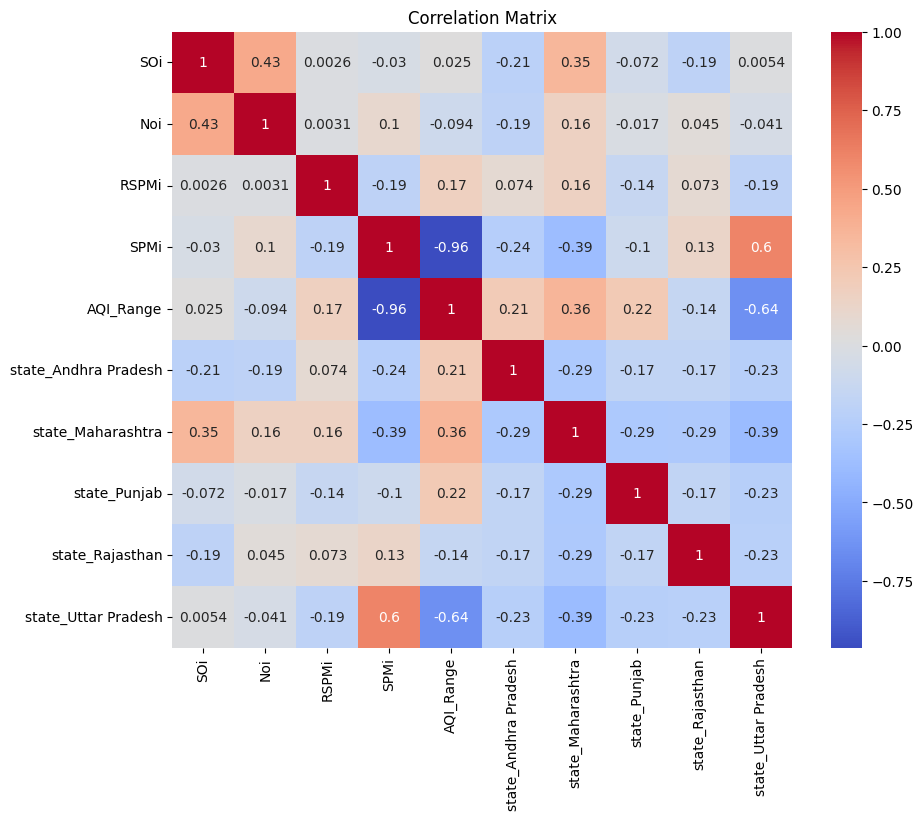

In [63]:
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_filtered[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [64]:
# du doan
# Reshape y_pred 
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((y_pred.shape[0], X_test.shape[2])), y_pred], axis=1)
)[:, -1]

# Reshape y_test 
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((y_test.shape[0], X_test.shape[2])), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

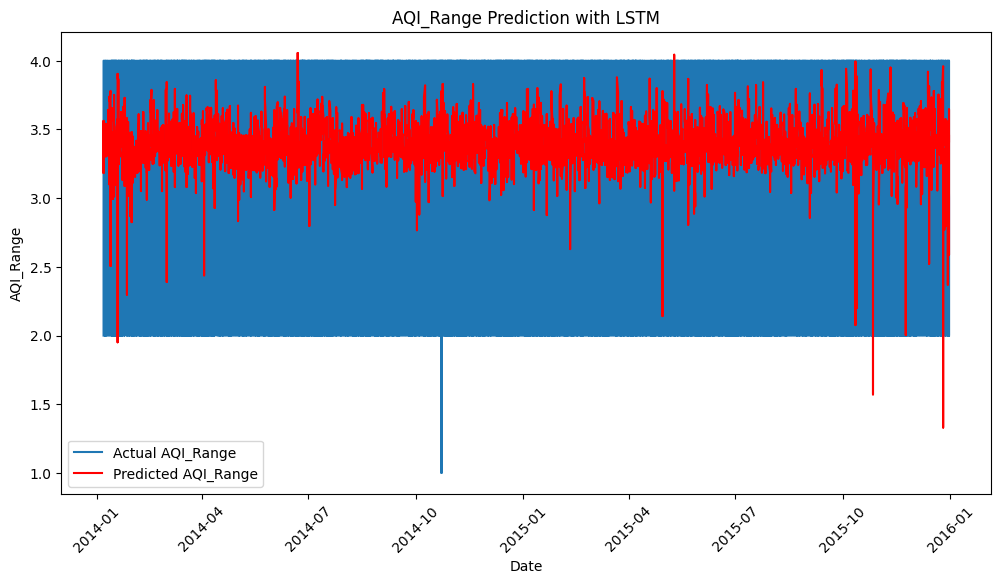

In [65]:
# lay ngay tap kiem tra
test_dates = df_filtered.index[-len(y_pred_rescaled):] 

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual AQI_Range')
plt.plot(test_dates, y_pred_rescaled, label='Predicted AQI_Range', color='red')
plt.title('AQI_Range Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('AQI_Range')
plt.legend()
# xoay nhan
plt.xticks(rotation=45)
plt.show()


# Test data

In [66]:
def prepare_new_data(new_data, scaler, encoder, state_columns, time_steps=30):
    # ma hoa state
    state_encoded = encoder.transform(new_data[['state']])
    state_df = pd.DataFrame(state_encoded, columns=state_columns)
    new_data_encoded = pd.concat([new_data.reset_index(drop=True), state_df], axis=1)

    # them cot AQI_Range gia tri mac dinh (0)
    new_data_encoded['AQI_Range'] = 0

    # chuan hoa du lieu
    input_features = ['SOi', 'Noi', 'RSPMi', 'SPMi'] + state_columns + ['AQI_Range']
    scaled_data = scaler.transform(new_data_encoded[input_features])

    # tao chuoi tho gain
    X = []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
    return np.array(X)

### Data preparation test

In [67]:
# du doan tren mot vung
new_data = pd.DataFrame({
    'date': pd.date_range(start='2024-01-01', periods=40),
    'state': ['Andhra Pradesh'] * 40,  
    'SOi': np.random.uniform(5, 15, 40),
    'Noi': np.random.uniform(10, 30, 40),
    'RSPMi': np.random.uniform(50, 100, 40),
    'SPMi': np.random.uniform(100, 200, 40)
})

# cot date lam index
new_data['date'] = pd.to_datetime(new_data['date'])
new_data.set_index('date', inplace=True)

# tao du lieu dau vao moi
X_new = prepare_new_data(new_data, scaler, encoder, state_columns, time_steps=30)


In [68]:
# du doan
y_pred_new = model.predict(X_new)

# chuan doi ve gia tri thuc
n_features = X_new.shape[2]  # Tổng số đặc trưng (features) trong scaler
y_pred_new_rescaled = scaler.inverse_transform(
    np.hstack([np.zeros((y_pred_new.shape[0], n_features - 1)), y_pred_new])
)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


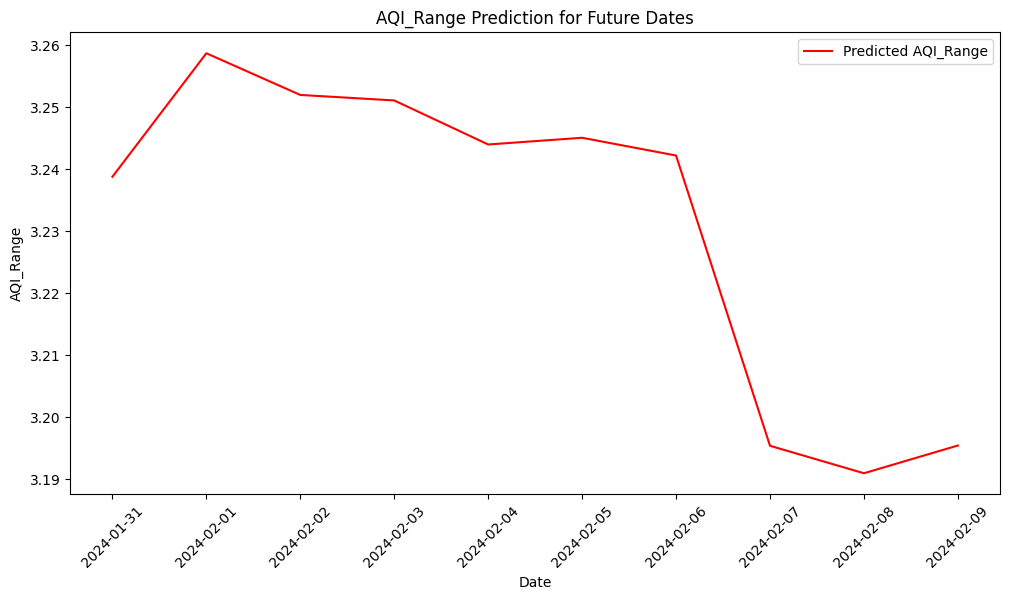

In [69]:
future_dates = new_data.index[-len(y_pred_new):]
plt.figure(figsize=(12, 6))
plt.plot(future_dates, y_pred_new_rescaled, label='Predicted AQI_Range', color='red')
plt.title('AQI_Range Prediction for Future Dates')
plt.xlabel('Date')
plt.ylabel('AQI_Range')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [70]:
# Ket qua 
predicted_df = pd.DataFrame({'Date': future_dates, 'Predicted_AQI_Range': y_pred_new_rescaled})
print(predicted_df)

        Date  Predicted_AQI_Range
0 2024-01-31             3.238778
1 2024-02-01             3.258707
2 2024-02-02             3.251980
3 2024-02-03             3.251092
4 2024-02-04             3.243985
5 2024-02-05             3.245068
6 2024-02-06             3.242203
7 2024-02-07             3.195358
8 2024-02-08             3.190924
9 2024-02-09             3.195403
